In [224]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

In [225]:
#Defining global constants
batch_size = 32

In [226]:
#Fixating seed to achieve reproducible results
np.random.seed(111)
torch.manual_seed(111)
torch.cuda.manual_seed(111)

In [227]:
#Importing train and test datasets
df_train = pd.read_csv(
    "https://media.githubusercontent.com/media/psi3471/datasets/main/disease_prediction/disease_train.csv"
).drop(columns=["Unnamed: 0"])

df_test = pd.read_csv(
    "https://media.githubusercontent.com/media/psi3471/datasets/main/disease_prediction/disease_test.csv"
).drop(columns=["Unnamed: 0"])

#Separating features and targets
X_train = df_train.iloc[:, 0:8].values
y_train = df_train.iloc[:, 8].values

X_test = df_test.iloc[:, 0:8].values
y_test = df_test.iloc[:, 8].values

In [228]:
#Defining a dataset class to handle the data
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [229]:
#Instantiating training and testing datasets
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

In [230]:
#Creating data loaders for the torch model
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

In [231]:
#Defining the model
import torch.nn as nn

# Define the neural network
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        # Linear layer with 8 inputs and 1 output (1 neuron)
        self.fc = nn.Linear(8, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

# Create an instance of the network
simple_model = MyNet()

# Move the model to GPU if available
if torch.cuda.is_available():
    simple_model = simple_model.cuda()


In [232]:
import torch.nn.functional as F

# Define the neural network
class ComplexModel(nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # linear output
        return x

# Create an instance of the network
complex_model = ComplexModel()

# Move the model to GPU if available
if torch.cuda.is_available():
    complex_model = complex_model.cuda()

In [233]:
import torch.optim as optim
from torch.optim import lr_scheduler

#Defining a function for training
def train_model(model, filename_weights):
    # Number of epochs
    n_epochs = 100

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    #Defining a learning rate scheduller:
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # List to store loss values for each epoch
    train_losses = []
    valid_losses = []

    # Initialize the early_stopping counter
    no_improvement = 0
    no_improvement_threshold = 5  # you can adjust this value
    best_valid_loss = float('inf') 

    # Training loop
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        
        # Training phase
        model.train()
        for data, target in train_loader:
            # If GPU is available, move data and target to GPU
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data.float())
            loss = criterion(output, target.view(-1, 1).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        # Validation phase
        model.eval()
        with torch.no_grad():
            for data, target in test_loader:
                if torch.cuda.is_available():
                    data, target = data.cuda(), target.cuda()
                    
                output = model(data.float())
                loss = criterion(output, target.view(-1, 1).float())
                valid_loss += loss.item() * data.size(0)

        # Calculate average losses
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(test_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        #Implementing early stopping to prevent overfitting
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), filename_weights)  # save the best model
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement == no_improvement_threshold:
                print("No improvement in validation loss for {} epochs. Stopping training.".format(no_improvement_threshold))
                break

        #Adapting learning rate
        scheduler.step()

        # Print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch+1, train_loss, valid_loss))
        
    return train_losses, valid_losses

In [234]:
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

def test_model(model,filename_weights):
    # Load the best model
    model.load_state_dict(torch.load(filename_weights))

    # Set model to evaluation mode
    model.eval()

    # Make predictions on the test data
    predictions = []
    targets = []

    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = model(data.float())
            pred = torch.round(torch.sigmoid(output))  # round the output to 0 or 1
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())

    # Compute metrics
    conf_mat = confusion_matrix(targets, predictions)
    accuracy = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions)

    print("Confusion Matrix:\n", conf_mat)
    print("\nAccuracy: ", accuracy)
    print("\nF1 Score: ", f1)


In [235]:
filename_weights = 'simple_model.pt'
train_losses, valid_losses = train_model(simple_model, filename_weights)

Epoch: 1 	Training Loss: 28.823559 	Validation Loss: 29.317455
Epoch: 2 	Training Loss: 24.003532 	Validation Loss: 24.092501
Epoch: 3 	Training Loss: 19.178257 	Validation Loss: 18.794109
Epoch: 4 	Training Loss: 14.450240 	Validation Loss: 13.801027
Epoch: 5 	Training Loss: 10.377748 	Validation Loss: 9.893726
Epoch: 6 	Training Loss: 7.745339 	Validation Loss: 7.776313
Epoch: 7 	Training Loss: 6.413761 	Validation Loss: 6.801940
Epoch: 8 	Training Loss: 5.871906 	Validation Loss: 6.386831
Epoch: 9 	Training Loss: 5.667207 	Validation Loss: 6.149708
Epoch: 10 	Training Loss: 5.512729 	Validation Loss: 5.968185
Epoch: 11 	Training Loss: 5.436734 	Validation Loss: 5.948352
Epoch: 12 	Training Loss: 5.423246 	Validation Loss: 5.930640
Epoch: 13 	Training Loss: 5.407960 	Validation Loss: 5.908004
Epoch: 14 	Training Loss: 5.392717 	Validation Loss: 5.891393
Epoch: 15 	Training Loss: 5.377757 	Validation Loss: 5.873049
Epoch: 16 	Training Loss: 5.362148 	Validation Loss: 5.853352
Epoch: 1

In [236]:
test_model(simple_model, filename_weights)

Confusion Matrix:
 [[61 44]
 [34 15]]

Accuracy:  0.4935064935064935

F1 Score:  0.2777777777777778


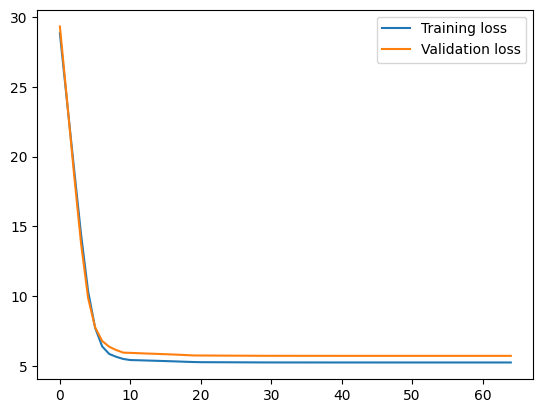

In [237]:
# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.show()

# Develloping a more complex architecture

In [238]:
filename_weights = 'complex_model.pt'
train_losses, valid_losses = train_model(complex_model, filename_weights)

Epoch: 1 	Training Loss: 1.537147 	Validation Loss: 0.875528
Epoch: 2 	Training Loss: 0.862967 	Validation Loss: 0.820029
Epoch: 3 	Training Loss: 0.776393 	Validation Loss: 0.717926
Epoch: 4 	Training Loss: 0.723981 	Validation Loss: 0.685957
Epoch: 5 	Training Loss: 0.663118 	Validation Loss: 0.608527
Epoch: 6 	Training Loss: 0.650769 	Validation Loss: 0.594666
Epoch: 7 	Training Loss: 0.627547 	Validation Loss: 0.600260
Epoch: 8 	Training Loss: 0.629435 	Validation Loss: 0.726630
Epoch: 9 	Training Loss: 0.638247 	Validation Loss: 0.605752
Epoch: 10 	Training Loss: 0.608898 	Validation Loss: 0.606323
Epoch: 11 	Training Loss: 0.603987 	Validation Loss: 0.579865
Epoch: 12 	Training Loss: 0.596813 	Validation Loss: 0.578958
Epoch: 13 	Training Loss: 0.595785 	Validation Loss: 0.574823
Epoch: 14 	Training Loss: 0.596334 	Validation Loss: 0.576370
Epoch: 15 	Training Loss: 0.596986 	Validation Loss: 0.577654
Epoch: 16 	Training Loss: 0.594161 	Validation Loss: 0.576101
Epoch: 17 	Traini

In [239]:
test_model(complex_model, filename_weights)

Confusion Matrix:
 [[93 12]
 [30 19]]

Accuracy:  0.7272727272727273

F1 Score:  0.4749999999999999
